In [1]:
from typing import Annotated, Literal, TypedDict
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from typing import Optional, Type
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import BaseTool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.callbacks.manager import CallbackManagerForToolRun
from langchain_core.output_parsers import StrOutputParser

In [2]:
model_name = 'dunzhang/stella_en_400M_v5'
model_kwargs = {'device': 'cuda', "trust_remote_code": True}

embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
)

vector_store = Chroma(
    collection_name="its_faq",
    persist_directory="../db",
    embedding_function=embedding_model,
    collection_metadata={"hnsw:space": "cosine"}
)

retriever = vector_store.as_retriever(
    search_kwargs={'k': 2}
)

/home/exouser/.conda/envs/ai-agent-askus/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/exouser/.conda/envs/ai-agent-askus/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/exouser/.conda/envs/ai-agent-askus/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_

In [4]:
class AnswerAboutSelfInput(BaseModel):
    query: str = Field(description="query about yourself or user greeting")

class AnswerAboutSelf(BaseTool):
    name = "answer_about_self"
    description = "Use this tool if the user query is a question about the chatbot. If the query is a greeting or a farewell.\nThe action input must be the user query unedited."
    args_schema: Type[BaseModel] = AnswerAboutSelfInput
    return_direct = True

    def _run(self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        system_prompt = (
            "Your name is Hoku. You are an assistant for answering questions about UH Manoa.\n"
            "You were initially created during the Hawaii Annual Code Challenge by team DarkMode.\n"
            "You are currently under development.\n"
            "Only respond with information given here.\n"
            "Answer concisely do not add any additional information.\n"
            "Reiterate the query then give a concise answer."
        )

        qa_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("human", "{query}"),
            ]
        )

        chain = qa_prompt | self.metadata['llm'] | StrOutputParser()
        return chain.invoke({"query": query})

In [5]:
class AnswerITSInput(BaseModel):
    query: str = Field(description="question related to tech")

class AnswerITS(BaseTool):
    name = "answer_its"
    description = "use this tool if the user has a question related to tech"
    args_schema: Type[BaseModel] = AnswerAboutSelfInput
    return_direct = True

    def _run(self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        system_prompt = (
            "Your name is Hoku. You are an assistant for answering questions about UH Manoa."
            "Answer the question given ONLY the provided context.\n"
            "If the answer DOES NOT appear in the context, say 'I'm sorry I don't know the answer to that'.\n"
            "Keep your answer concise, informative and with a conversational tone.\n"
            "DO NOT mention the context or the text provided."
            "if the user greets you, greet them back nicely"
        )

        qa_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("human", "context:{context}\n\nquestion: {query}"),
            ]
        )

        chain = qa_prompt | self.metadata['llm'] | StrOutputParser()
        return chain.invoke({"query": query, "context": retriever.invoke(query)})

In [4]:
@tool
def search(query: str) -> str:
    """Use this tool to surf the web about weather updates"""

    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 89 degrees and sunny."

In [6]:
llm = ChatOpenAI(
    api_key="ollama",
    model="mistral-nemo:latest",
    base_url="http://localhost:11434/v1",
    temperature=0,
)

tools = [AnswerAboutSelf(metadata={'llm': llm}), AnswerITS(metadata={'llm': llm})]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

In [7]:
llm.invoke("hello")

AIMessage(content="Hello! How can I assist you today? Let me know if you have any questions, need some advice, or just want to chat. (I'm here to help!) 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 4, 'total_tokens': 43}, 'model_name': 'mistral-nemo:latest', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-e2bce5d5-bc55-483b-91fb-5a95333a27e3-0', usage_metadata={'input_tokens': 4, 'output_tokens': 39, 'total_tokens': 43})

In [8]:
from langgraph.prebuilt import create_react_agent

In [9]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tools"

    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [10]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [11]:
def should_return_direct(state: MessagesState) -> Literal["agent", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    return "__end__"

In [17]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", 'agent')

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

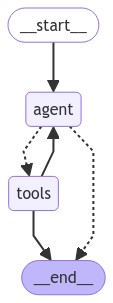

In [18]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
inputs = {"messages": [("user", "what is your name?")]}
print_stream(app.stream(inputs, config={"configurable": {"thread_id": 42}}, stream_mode="values"))

================================ Human Message =================================

what is your name?
================================== Ai Message ==================================
Tool Calls:
  answer_about_self (call_5uaxqlt1)
 Call ID: call_5uaxqlt1
  Args:
    query: what is your name?
================================= Tool Message =================================
Name: answer_about_self

Your question was: "What is your name?"
My name is Hoku.
================================== Ai Message ==================================

Hi there! How can I assist you today?


In [33]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="what is duo mobile?")]},
    config={"configurable": {"thread_id": 42}}
)

print(final_state["messages"][-1].content)

 How do I use duo mobile?

To use Duo Mobile for two-factor authentication, follow these steps:

1. **Install Duo Mobile**:
	* For iOS: Search for "Duo Mobile" in the Apple App Store or click this link: <https://apps.apple.com/us/app/duo-mobile/id586372490>
	* For Android: Search for "Duo Mobile" in the Google Play Store or click this link: <https://play.google.com/store/apps/details?id=com.duosecurity.duomobile>
	* Alternatively, use the Duo Mobile Web Application on your computer at <https://duo.com/mobile>
2. **Enroll your device**:
	* You'll need an enrollment link or invitation from your organization or service provider to add Duo Mobile as a second factor for your account.
	* Tap on the enrollment link or follow the instructions provided by your organization.
	* Once you've opened the Duo Mobile app, tap "Add Account" and scan the QR code displayed on the enrollment page using the app's camera.
	* Enter the passcode (if required) and follow any additional prompts to complete the 